In [130]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod

In [131]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires Tensorflow v2.')

In [132]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_test = x_test[0:100]
y_test = y_test[0:100]

# Train and evaluate a baseline classifier

In [133]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']);

In [134]:
model.fit(x_train, y_train, epochs=3);

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 3s 58us/sample - loss: 0.2971 - accuracy: 0.9133
Epoch 2/3
60000/60000 [==============================] - 3s 54us/sample - loss: 0.1436 - accuracy: 0.9574
Epoch 3/3
60000/60000 [==============================] - 3s 54us/sample - loss: 0.1051 - accuracy: 0.9678


#### Answer for 1(a) point ii :

In [135]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 2ms/sample - loss: 0.0192 - accuracy: 1.0000
Accuracy on test data: 100.00%


In [136]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

# Fast Gradient Sign Method attack on baseline classifier

In [137]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
x_test_adv_fgsm = attack_fgsm.generate(x_test)

#### Answer for 1(a) point iii :

In [138]:
loss_test, accuracy_test = model.evaluate(x_test_adv_fgsm, y_test)
perturbation = np.mean(np.abs((x_test_adv_fgsm - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

100/100 [==============================] - 0s 55us/sample - loss: 16.5799 - accuracy: 0.0000e+00
Accuracy on adversarial test data: 0.00%
Average perturbation: 0.18


#### Answer for 1(a) point i :

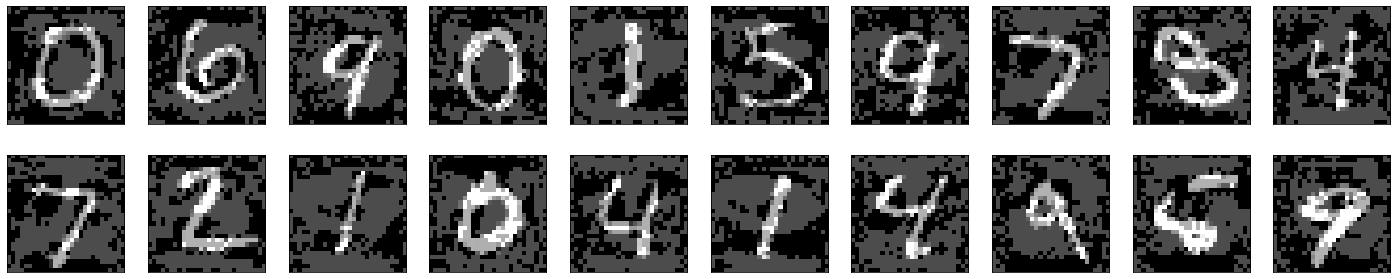

In [139]:
fig    = plt.figure(figsize=(50, 10))
cols   = 20
images = list(x_test_adv_fgsm[:cols])

for i in range(0, len(images)):
    ax = fig.add_subplot((i/10)+1, cols, (i%10)+1)
    ax.tick_params(axis='both', which='both',
                   bottom=False, top=False,
                   right=False, left=False,
                   labelbottom=False, labelleft=False)
    plt.imshow(images[i], cmap='gray')

plt.show()

# Carlini&Wagner Infinity-norm attack on baseline classifier

In [140]:
attack_cw = CarliniLInfMethod(classifier=classifier, eps=0.3, max_iter=100, learning_rate=0.01)
x_test_adv_cw = attack_cw.generate(x_test)

C&W L_inf: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.82s/it]


#### Answer for 1(a) point iii :

In [141]:
loss_test, accuracy_test = model.evaluate(x_test_adv_cw, y_test)
perturbation = np.mean(np.abs((x_test_adv_cw - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

100/100 [==============================] - 0s 99us/sample - loss: 2.0619 - accuracy: 0.1100
Accuracy on adversarial test data: 11.00%
Average perturbation: 0.03


#### Answer for 1(a) point i :

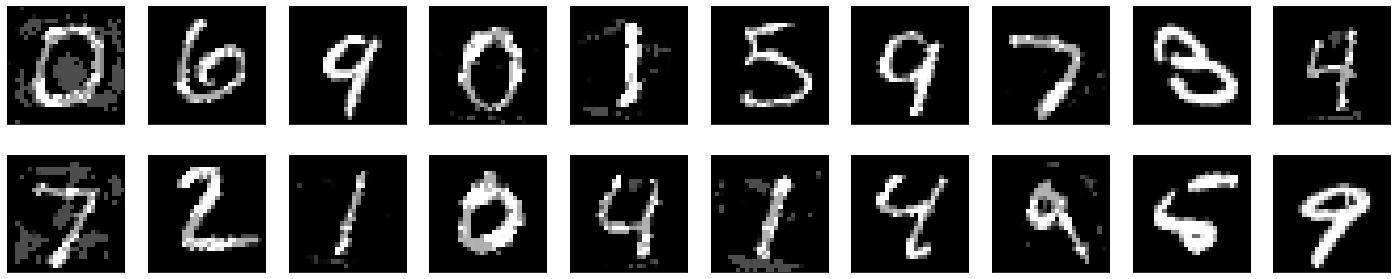

In [142]:
fig    = plt.figure(figsize=(50, 10))
cols   = 20
images = list(x_test_adv_cw[:cols])

for i in range(0, len(images)):
    ax = fig.add_subplot((i/10)+1, cols, (i%10)+1)
    ax.tick_params(axis='both', which='both',
                   bottom=False, top=False,
                   right=False, left=False,
                   labelbottom=False, labelleft=False)
    plt.imshow(images[i], cmap='gray')

plt.show()

# Adversarially train a robust classifier

In [143]:
from keras.models import load_model

from art.config import ART_DATA_PATH
from art.utils import load_dataset, get_file
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer

In [144]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')

x_test = x_test[0:100]
y_test = y_test[0:100]


path = get_file('mnist_cnn_robust.h5', extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
robust_classifier_model = load_model(path)
robust_classifier = KerasClassifier(clip_values=(min_, max_), model=robust_classifier_model, use_logits=False)

robust_classifier_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1639424   
_________________________________________________________________
dense_4 (Dense)              (None, 10)              

In [145]:
attacks = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.01, max_iter=40)

In [146]:
x_test_robust_pred = np.argmax(robust_classifier.predict(x_test[:100]), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test[:100], axis=1))

print('Accuracy on test data: {:4.2f}%'.format(nb_correct_robust_pred))

Accuracy on test data: 99.00%


# Fast Gradient Sign Method attack on robust classifier

In [147]:
attacker_robust_fgsm = FastGradientMethod(robust_classifier, eps=0.5)
x_test_adv_robust_fgsm = attacker_robust_fgsm.generate(x_test[:100])

#### Answer for 1(a) point iv :

In [148]:
x_test_adv_robust_pred_fgsm = np.argmax(robust_classifier.predict(x_test_adv_robust_fgsm), axis=1)
nb_correct_adv_robust_pred_fgsm = np.sum(x_test_adv_robust_pred_fgsm == np.argmax(y_test[:100], axis=1))

print('Accuracy on test data: {:4.2f}%'.format(nb_correct_adv_robust_pred_fgsm))

Accuracy on test data: 79.00%


# Carlini&Wagner Infinity-norm attack on robust classifier

In [149]:
attackker_robust_cw = CarliniLInfMethod(classifier=robust_classifier, eps=0.3, max_iter=100, learning_rate=0.01)
x_test_adv_robust_cw = attackker_robust_cw.generate(x_test)

C&W L_inf: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.28s/it]


#### Answer for 1(a) point iv :

In [150]:
x_test_adv_robust_pred_cw = np.argmax(robust_classifier.predict(x_test_adv_robust_cw), axis=1)
nb_correct_adv_robust_pred_cw = np.sum(x_test_adv_robust_pred_cw == np.argmax(y_test[:100], axis=1))

print('Accuracy on test data: {:4.2f}%'.format(nb_correct_adv_robust_pred_cw))

Accuracy on test data: 100.00%
